## Import Autophagy Package

In [25]:
import importlib
import run_sim
importlib.reload(run_sim)
from run_sim import output_path, simulation_settings

## Read results from json Files
The results of the simulation are saved in json files.
Due to the parallelized nature of the simulation, not all results are in one big json file but rather in multiple batches. We therefore need to combine these batches to obtain a complete set for a given iteration.

In [26]:
import os
from pathlib import Path
import json

def combine_batches(run_directory):
    # Opens all batches in a given directory and stores
    # them in one unified big list
    combined_batch = []
    for batch_file in os.listdir(run_directory):
        f = open(run_directory / batch_file)
        b = json.load(f)["data"]
        combined_batch.extend(b)
    return combined_batch

def get_cells_at_iterations(output_path):
    # Uses the previously defined funtion [combine_batches]
    # to read all stored cells at all iterations and stores
    # them in a dictionary.
    dir = Path(output_path) / "cell_storage/json/"
    runs = [(x, dir / x) for x in os.listdir(dir)]
    result = []
    for (n_run, run_directory) in runs:
        result.extend([{"iteration":int(n_run)} | c for c in combine_batches(run_directory)])
    return result

cells_at_iter = get_cells_at_iterations(output_path)

We want to inspect which entries our generated dataset has. Therefore, we normalize the dict, transforming it into a dataframe.
Afterwards, we display all columns.

In [27]:
import pandas as pd

df = pd.json_normalize(cells_at_iter)
for col in df.columns:
    print(col)

iteration
identifier
element.id
element.parent_id
element.cell.mechanics.mechanics.pos
element.cell.mechanics.mechanics.vel
element.cell.mechanics.mechanics.mass
element.cell.mechanics.mechanics.damping
element.cell.mechanics.mechanics.kb_temperature
element.cell.mechanics.mechanics.update_interval
element.cell.mechanics.mechanics.random_vector
element.cell.interaction.species
element.cell.interaction.cell_radius
element.cell.interaction.potential_width
element.cell.interaction.well_depth
element.cell.interaction.cutoff
element.cell.interaction.bound
element.cell.interaction.avidity
element.cell.interaction.neighbour_count


## Analysis
1. Determine how the Cargo size changes over the course of the simulation
2. Determine if ATG11Receptor actually clusters

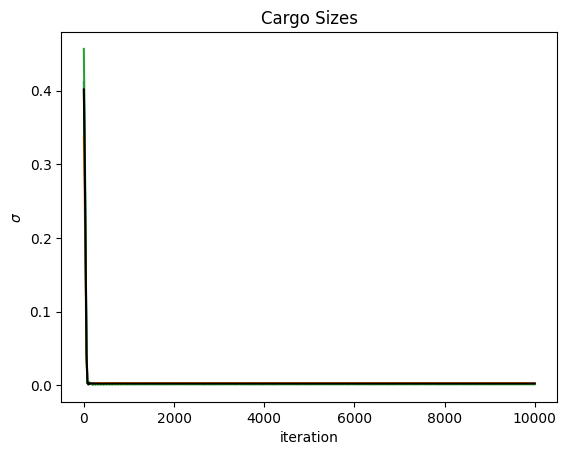

In [28]:
import matplotlib.pyplot as plt
import numpy as np


gr = df[df["element.cell.interaction.species"]=="Cargo"].groupby(["iteration"])["element.cell.mechanics.mechanics.pos"]
std = np.array([[*iteration, *np.std([np.array(gi) for gi in g], axis=0)] for (iteration, g) in gr])

fig, ax = plt.subplots()

ax.plot(std[:,0], std[:,1:])
ax.plot(std[:,0], np.average(std[:,1:], axis=1), color="black")
ax.set_title("Cargo Sizes")
ax.set_ylabel("$\\sigma$")
ax.set_xlabel("iteration")
plt.show(fig)

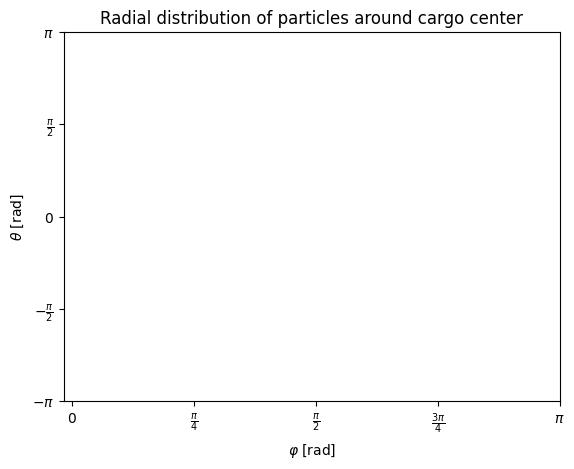

In [29]:
max_iter = max(df["iteration"])
cargo_at_end = df[(df["iteration"]==max_iter) & (df["element.cell.interaction.species"]=="Cargo")]["element.cell.mechanics.mechanics.pos"]
cargo_at_end = np.array([np.array(elem) for elem in cargo_at_end])
non_cargo_at_end = df[(df["iteration"]==max_iter) & (df["element.cell.interaction.species"]!="Cargo")]["element.cell.mechanics.mechanics.pos"]
non_cargo_at_end = np.array([np.array(elem) for elem in non_cargo_at_end])
cargo_middle = np.average(non_cargo_at_end, axis=0)

def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

non_cargo_at_end_spherical = appendSpherical_np(non_cargo_at_end - cargo_middle)
r = non_cargo_at_end_spherical[:,3]
r_inv = np.max(r) - r
phi = non_cargo_at_end_spherical[:,4]
theta = non_cargo_at_end_spherical[:,5]

fig, ax = plt.subplots()
ax.set_title("Radial distribution of particles around cargo center")
ax.scatter(phi, theta, s=r_inv, alpha=0.5)
ax.set_xlabel("$\\varphi$ [rad]")
ax.set_ylabel("$\\theta$ [rad]")
ax.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels(["$0$", "$\\frac{\\pi}{4}$", "$\\frac{\\pi}{2}$", "$\\frac{3\\pi}{4}$", "$\\pi$"])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(["$-\\pi$", "$-\\frac{\\pi}{2}$", "$0$", "$\\frac{\\pi}{2}$", "$\\pi$"])
plt.show(fig)

## Plot Result
We visualize the results in 3D.
Therefore we use `pyvista` which internally uses `vtk` as a backend.
Since all of our particles are represented as 3D-spheres, we also display them as such.

In [30]:
import pyvista as pv
import numpy as np
import multiprocessing as mp

def generate_spheres(df, iteration):
    # Filter for only particles at the specified iteration
    df_filtered = df[df["iteration"]==iteration]

    # Create a dataset for pyvista for plotting
    pset = pv.PolyData(np.array([np.array(x) for x in df_filtered["element.cell.mechanics.mechanics.pos"]]))

    # Extend dataset by species and diameter
    pset.point_data["diameter"] = 2.0*df_filtered["element.cell.interaction.cell_radius"]
    pset.point_data["species"] = df_filtered["element.cell.interaction.species"]

    # Create spheres glyphs from dataset
    sphere = pv.Sphere()
    spheres = pset.glyph(geom=sphere, scale="diameter", orient=False)

    return spheres

def save_snapshot(iteration):
    spheres = generate_spheres(df, iteration)

    spheres.plot(
        off_screen=True,
        screenshot=Path(output_path) / "snapshot_{:08}.png".format(iteration),
        scalars="species",
        scalar_bar_args={
            "title":"Species",
        },
        cpos=[
            (
                -1.5*simulation_settings.domain_size,
                -1.5*simulation_settings.domain_size,
                -1.5*simulation_settings.domain_size
            ),(
                25,
                25,
                25
            ),(
                0.0,
                0.0,
                0.0
            )
        ],
        jupyter_backend='none',
    )

We can save single snapshots or even use all processes of our device to save snapshots for every iteration.
The 2nd approach will take up all resources by default. If you want to limit this, have a look at the [Pool object of the multiprocessing](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool) module.

In [31]:
# Save all snapshots
with mp.Pool(14) as p:
    p.map(save_snapshot, np.unique(df["iteration"]))

In [32]:
# Also create a movie with ffmpeg
bashcmd = f"ffmpeg -y -r 30 -f image2 -pattern_type glob -i '{output_path}/*.png' -c:v h264 -pix_fmt yuv420p -strict -2 {output_path}/amovie_4.mp4"
os.system(bashcmd)

ffmpeg version n6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.2.1 (GCC) 20230801
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpl --enable-libvpx --enable-libwebp --enable-libx264 --enable

0